# FIGURE 2

In [18]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import ComHyperPar
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnKMEANS, ClusterAverages
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [19]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

header = A_r.columns
treatments = A_r.columns[2:]

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=False, FCfilter=True, log2T=True)

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

### Phenotypes

Cell Viability:

In [20]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)
Y_cv = Y_cv[Y_cv["Elapsed"] == 87].iloc[0, 1:11]

## 1. Cross-validation

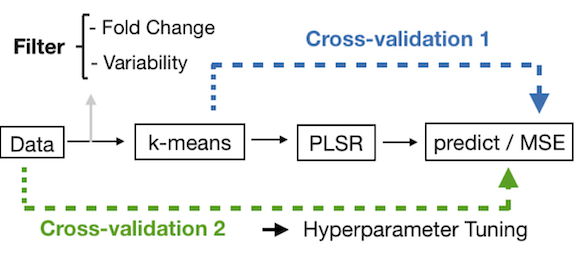

In [21]:
from IPython.display import Image
Image(filename='Model_pipeline.jpg')

### 1.1 Strategy 1: R2Y/Q2Y with Raw Data

Cross-validation fitting the entire pre-processed raw data into PLSR model:

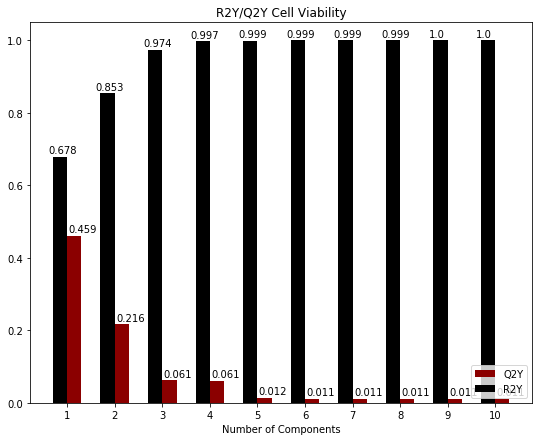

In [22]:
maxComp = Y_cv.shape[0]
Q2Y = Q2Y_across_components(data, Y_cv, maxComp+1)
R2Y = R2Y_across_components(data, Y_cv, maxComp+1)

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))  

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(9,7))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkred")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=4)
disp_values(Q2Y,1.03,0.01,3)
disp_values(R2Y,0.6,0.01,3)

### 1.2 Strategy 1: R2Y/Q2Y after k-means clustering (k=5)

Cross-validation fitting averages of k-means clusters into the PLSR model. Number of clusters must be set in advance:

In [23]:
kmeans = KMeans(4).fit(data.T)
labels = kmeans.labels_
centers, _ = ClusterAverages(data, labels)

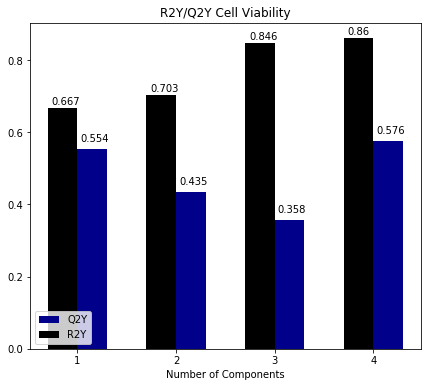

In [24]:
maxComp = 4
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

### 1.3 Strategy 2: Gridsearch

Cross-validation fitting averages of k-means clusters into the PLSR model. Simulatenous tuning of number of clusters and number of components using GridSearch:

In [25]:
CVresults_max, CVresults_min, best_params = ComHyperPar(data, Y_cv)
CVresults_min.iloc[:20, :]

,#Clusters,#Components,mean_test_scores,mean_train_scores
0,2,1,-522.925267,-331.982342
1,2,2,-322.541456,-208.687009
2,3,1,-270.870031,-194.283217
3,3,2,-351.843320,-185.309151
4,3,3,-386.705193,-174.440553
5,4,1,-283.094093,-205.172282
6,4,2,-333.332415,-180.906262
7,4,3,-417.165699,-101.512865
8,4,4,-260.736036,-74.820457
9,5,1,-278.411769,-206.624655


## 2. Model Predicted vs Actual for best Hyperparameter Set

In [26]:
ncl, ncomp = 4, 4

### 2.1 Fitting Raw Data, without k-means clustering, into PLSR:

Pearson's R:  0.5247425577098306 
 p-value:  0.11940257508604928


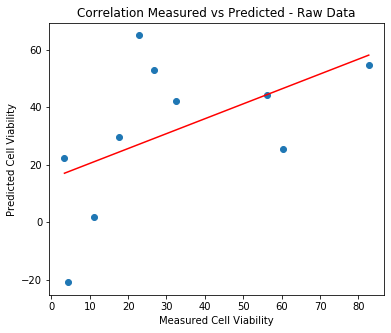

In [27]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Raw Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.2 With CV Strategy 1:

Pearson's R:  0.7637151825268345 
 p-value:  0.010138229236345634


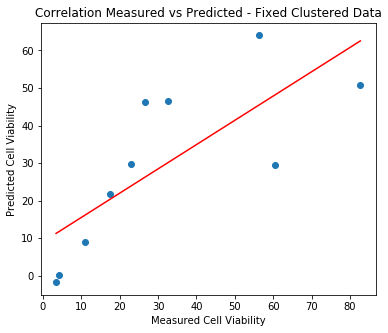

In [28]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(centers, Y_cv, PLSRegression(ncomp), fig, "none", axs)
plt.title("Correlation Measured vs Predicted - Fixed Clustered Data")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

### 2.3 With CV Strategy 2:

In [29]:
estimators = [('kmeans', MyOwnKMEANS(4)), ('plsr', PLSRegression(4))]
pipe = Pipeline(estimators)

In [30]:
X_scores, Y_scores = pipe.fit_transform(data, Y_cv)
X_scores, Y_scores = pipe.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = pipe.named_steps.plsr.x_loadings_[:, 0], pipe.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = pipe.named_steps.plsr.y_loadings_[:, 0], pipe.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.7900635588924584 
 p-value:  0.0065389938273012855


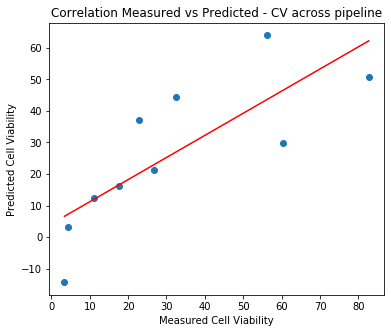

In [31]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, pipe, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

## 3. PLSR scores and loadings 

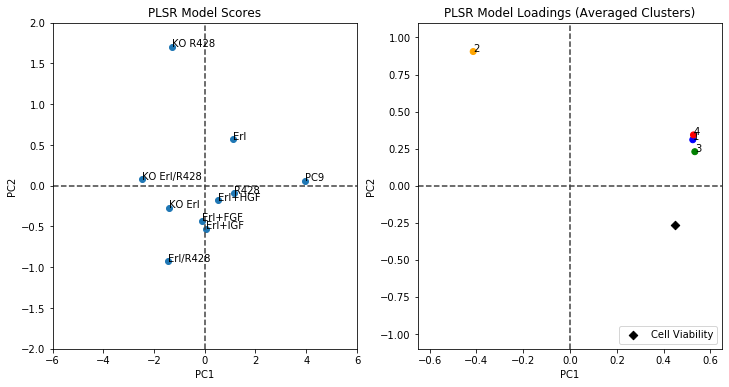

In [32]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))
colors_ = ["blue", "orange", "green", "red"]


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
axs[0].set_xlim([-6, 6])
axs[0].set_ylim([-2, 2])

for i, txt in enumerate(["1", "2", "3", "4"]):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=4)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.65, 0.65])
axs[1].set_ylim([-1.1, 1.1]);

In [33]:
clustermembers = pipe.named_steps.kmeans.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,"1-phosphatidylinositol 4,5-bisphosphate phosph...",RNPGFyVEANP,"10 kDa heat shock protein, mitochondrial",PEYGGtKVVLD,14-3-3 protein zeta/delta,LLSVAyKNVVG,Abl interactor 2,VVPNDyVPSPT
1,14-3-3 protein epsilon,GDYHRyLAEFA,182 kDa tankyrase-1-binding protein,GPPARsPSQDF,"Actin, cytoplasmic 1",ISKQEyDESGP,"Actin, cytoplasmic 1",LTERGySFTTT
2,ADP-ribosylation factor 4,KTTILyKLKLG,60S acidic ribosomal protein P2,yVASYL,Adapter molecule crk,QEEAEyVRALF,Activated CDC42 kinase 1,VSSTHyYLLPE
3,ADP-ribosylation factor-like protein 11,KTTLLyKLKGH,60S ribosomal protein L22-like 1,TYELRyFQISQ,Afadin,TYTREyFTFPA,Aldo-keto reductase family 1 member B1,AIDVGyRHIDC
4,ARF GTPase-activating protein GIT1,DDQHDyDSVAs,ADP/ATP translocase 2,ANVIRyFPTQA,BAG family molecular chaperone regulator 3,HQAQKtHYPAQ,Aldo-keto reductase family 1 member C3,ASHPNyPYSDE
5,ATPase WRNIP1,AGEEHyNCISA,ARF GTPase-activating protein GIT1,GADSDyENTQS,BAG family molecular chaperone regulator 3,THQPVyHKIQG,Alpha-actinin-1,NKHTNyTMEHI
6,Abl interactor 1,NTPYKtLEPVK,Actin-related protein 3,EPEDHyFLLTE,Band 4.1-like protein 2,EGDNIyVRHSN,Annexin A2,DARDLyDAGVK
7,Actin filament-associated protein 1-like 2,DEEYIyMNKVT,"Adenylate kinase 2, mitochondrial",AAEPEyPKGIR,Band 4.1-like protein 2,KKQKSyTLVVA,Annexin A2,GSVKAyTNFDA
8,Actin filament-associated protein 1-like 2,SPDHLySFRIL,Bifunctional purine biosynthesis protein PURH,QMPLRyGMNPH,Brain-specific angiogenesis inhibitor 1-associ...,VVRKDyDTLSK,Annexin A5,GDTSGyYQRML
9,"Actin, cytoplasmic 1",RDLTDyLMKIL,Breast cancer anti-estrogen resistance protein 1,PAPDLyDVPPG,Catenin delta-1,GGSDNyGSLSR,Anoctamin-1,RVNEKySTLPA


#### Cluster Averages across Conditions

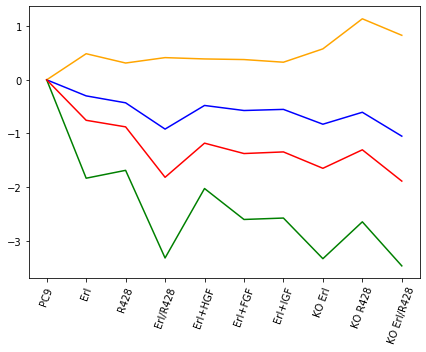

In [34]:
fig = plt.figure(figsize=(7,5))
colors_ = ["blue", "orange", "green", "red"]

centers = pipe.named_steps.kmeans.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);